# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)
11. "Monitoraggio settimanale - Ministero della Salute" check [here](http://www.salute.gov.it/portale/nuovocoronavirus/archivioNotizieNuovoCoronavirus.jsp?lingua=italiano&tipo=Report+settimanale+Covid-19&btnCerca=cerca) for new weekly updates.
12. "Monitoraggio settimale" by Istituto Superiore di Sanità, detailed reports, [here](https://www.iss.it/monitoraggio-settimanale)

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import os
import locale
locale.setlocale(locale.LC_TIME, "it_IT.UTF8")
from datetime import datetime, timedelta
from matplotlib import pyplot as plt, dates as mdates
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan, RSVD_smooth_data_generic

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
date_ = os.environ.get("REF_DATE")
if date_ is None:
    date_ = "2021-10-31"
print(date_)

2021-10-31


In [4]:
pastdays='000'

## Rt gamma parameters:

In [5]:
alpha = 1.87
beta = 0.28

ALPHA=100.

## Load DPC data, smooth them and compute naive Rt

In [6]:
DPC_data = DPC.load_daily_cases_from_github()
TIMESTEPS, FIRST_CASI_SOSP_DIAGNOSTICO = DPC.preprocess(DPC_data)
DPC.compute_first_diffs(DPC_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(DPC_data, regularizer)
DPC.bulk_compute_naive_Rt(DPC_data, alpha=alpha, beta = beta)

{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati': 'hospitalized_cumulative',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati_smoothed': 'hospitalized_cumulative',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.999998029019157
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999977294945851
deceduti_giornalieri_smoothed - TIC R2: 0.9999986548937675
nuovi_positivi_smoothed - TIC R2: 0.9999988341587495
nuovi_casi_da_sospetto_diagnostico_smooth

# Use RSVD: Regularized Singular Value Decomposition

RSVD allows to detect the seasonal component of the signal.

In the case of DPC `nuovi_positivi` we have a **weekly seasonality**, hence `season_period = 7`

RSVD has been proposed by Wei Lin, Jianhua Huang (Texas A&M University), Tucker Mcelroy (U.S. Census Bureau), in this [paper](https://www.researchgate.net/publication/327256122_Time_Series_Seasonal_Adjustment_Using_Regularized_Singular_Value_Decomposition)

It essentially casts the signal vector into a matrix whose columns are the seasons and the rows are the repetitive periods of a complete series of seasons. In our case the matrix shape will be `(~len(signal) / 7, 7)`.
Singular Value Decomposition is applied to the matrix so that singular values represent the seasonal component of the signal. Each (7 in our case) seasonal component is regularized via Tikhonov, following the hypotheis that each season component, period after period, must change smoothly. The Tikhonov regularization paramether is fitted via "leave one out cross validation".

The advantage of this method with respect to the SARIMA approach is that **we don't need to take moving averages**, and we don't need to tune any metaparameter of the model.

We wrote the python porting of the original R code.
The python porting is available from the following namespace:
```
import covid19_pytoolbox.smoothing.seasonalRSVD
```

The following features have been added to the original work:
- RSVD is applied by means of two different classes:
  - `SeasonalRegularizer` applies RSVD to the plain data
  - `LogSeasonalRegularizer` applies RSVD on the logarithm of the data to remove exponential trends; the inverse functions are correctly applied before returning the outputs, to remove the effects of taking the logarithm on the original signal
- both classes accept a `difference_degree` parameters; if greater then 0, the `n-th = difference_degree` difference is taken on the original signal prior to apply RSVD; this is helpful to remove non-stationarity in the original data
- the `adfuller` test can be performed on the input data to check (manually) if any non-stationary component is present
- the Tikhonov regularized trend is extracted from the deseasoned signal
- residuals are computed as differences between the deseasoned signal and the smoothed trend; relative residuals are also computed by the `LogSeasonalRegularizer`
- the signal is left truncated to obtain the RSVD matrix; before returning, the outputs are padded with `np.nan` to the left, to rebuild the original vector shape


In [7]:
DPC.RSVD_smooth_data(DPC_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

[   'nuovi_positivi',
    'tamponi_giornalieri',
    'nuovi_ospedalizzati',
    'deceduti_giornalieri',
    'ingressi_terapia_intensiva']
nuovi_positivi_deseason
info_cri:  -2.363850178270464
info_cri:  -2.1503298568102958
TIC R2: 0.9939721192642933
patterns: 1
(   -7.01314611419527,
    6.839359040249895e-10,
    19,
    594,
    {   '1%': -3.441406876071572,
        '10%': -2.5693678601956718,
        '5%': -2.866418015869717},
    -439.5170282516631)
new columns generated:
[   'nuovi_positivi_deseason',
    'nuovi_positivi_deseason_seasonality',
    'nuovi_positivi_deseason_smoothed',
    'nuovi_positivi_deseason_residuals',
    'nuovi_positivi_deseason_relative_residuals',
    'nuovi_positivi_deseason_smoothed_Rt']
tamponi_giornalieri_deseason
info_cri:  -2.4144919737647994
info_cri:  -1.950549783173751
TIC R2: 0.9828086022607858
patterns: 1
(   -8.657970995180813,
    4.909817602225232e-14,
    19,
    594,
    {   '1%': -3.441406876071572,
        '10%': -2.5693678601956718,
    

## Plotting the signal after applying RSVD

- the blue line is the original signal
- the violet line represent the oscillating seasonal component
- the orange line is the deseasoned signal
  - we can see how the orange line is much less oscillating with respect to the blue one, as RSVD succeded in removing the seasonal component
- the red line represents the smoothed trend of the deseasoned signal

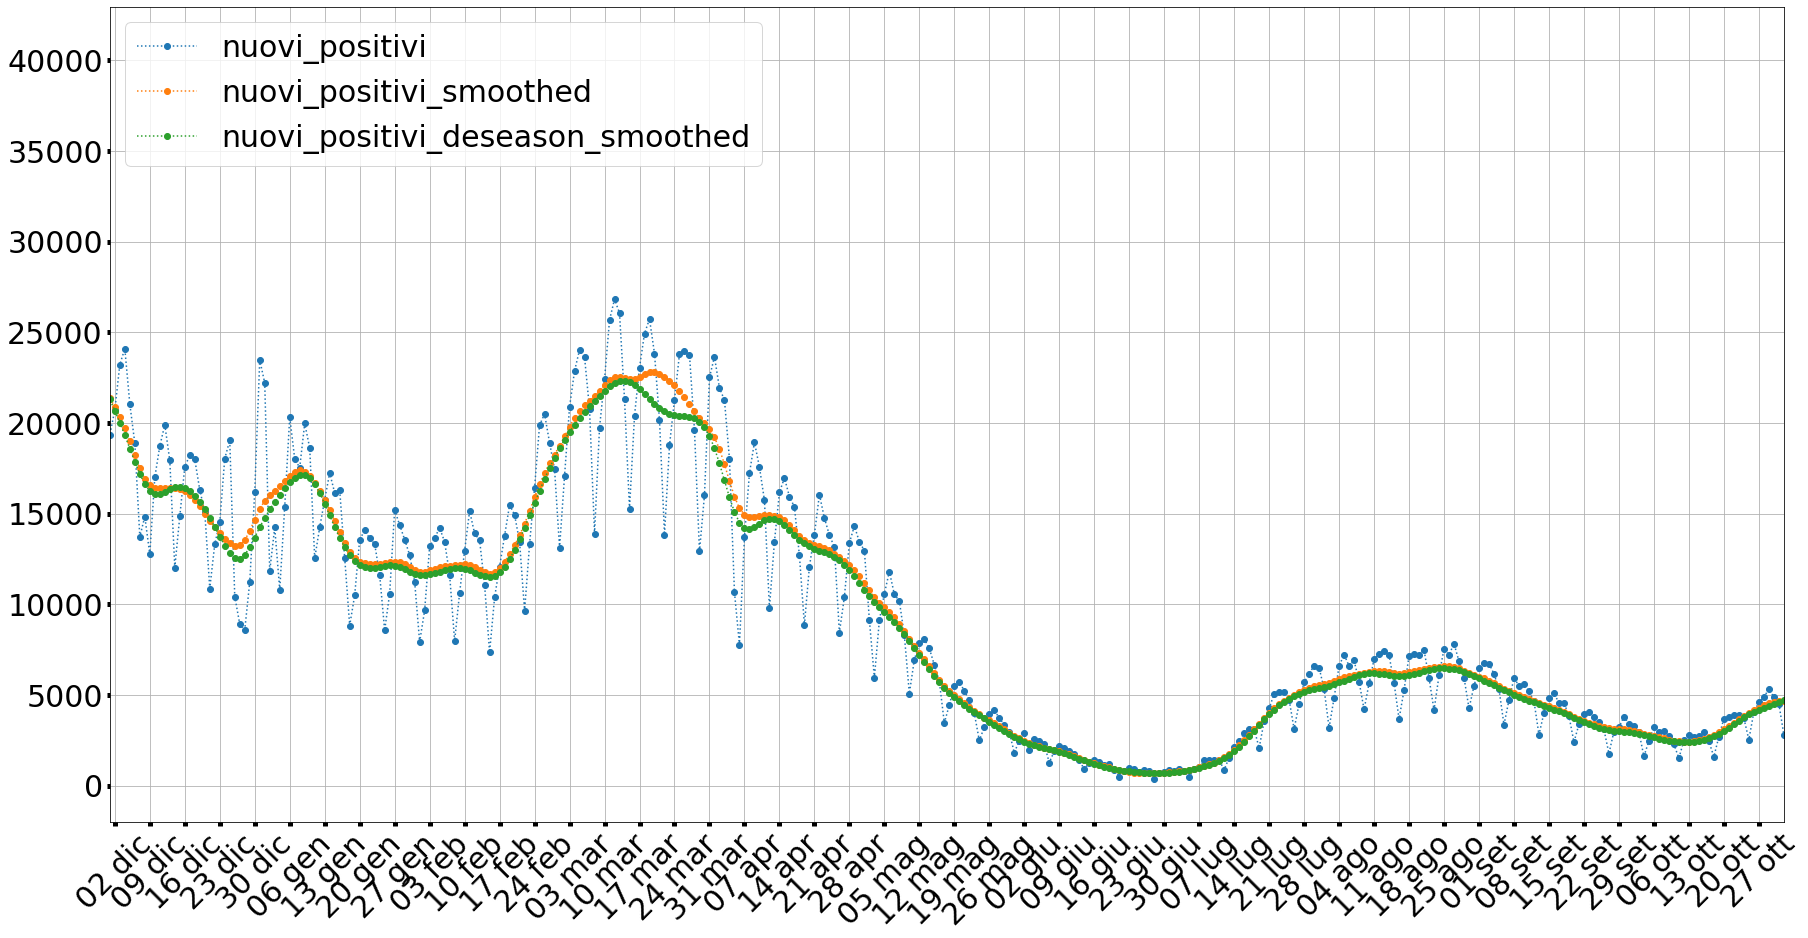

In [8]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,12,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

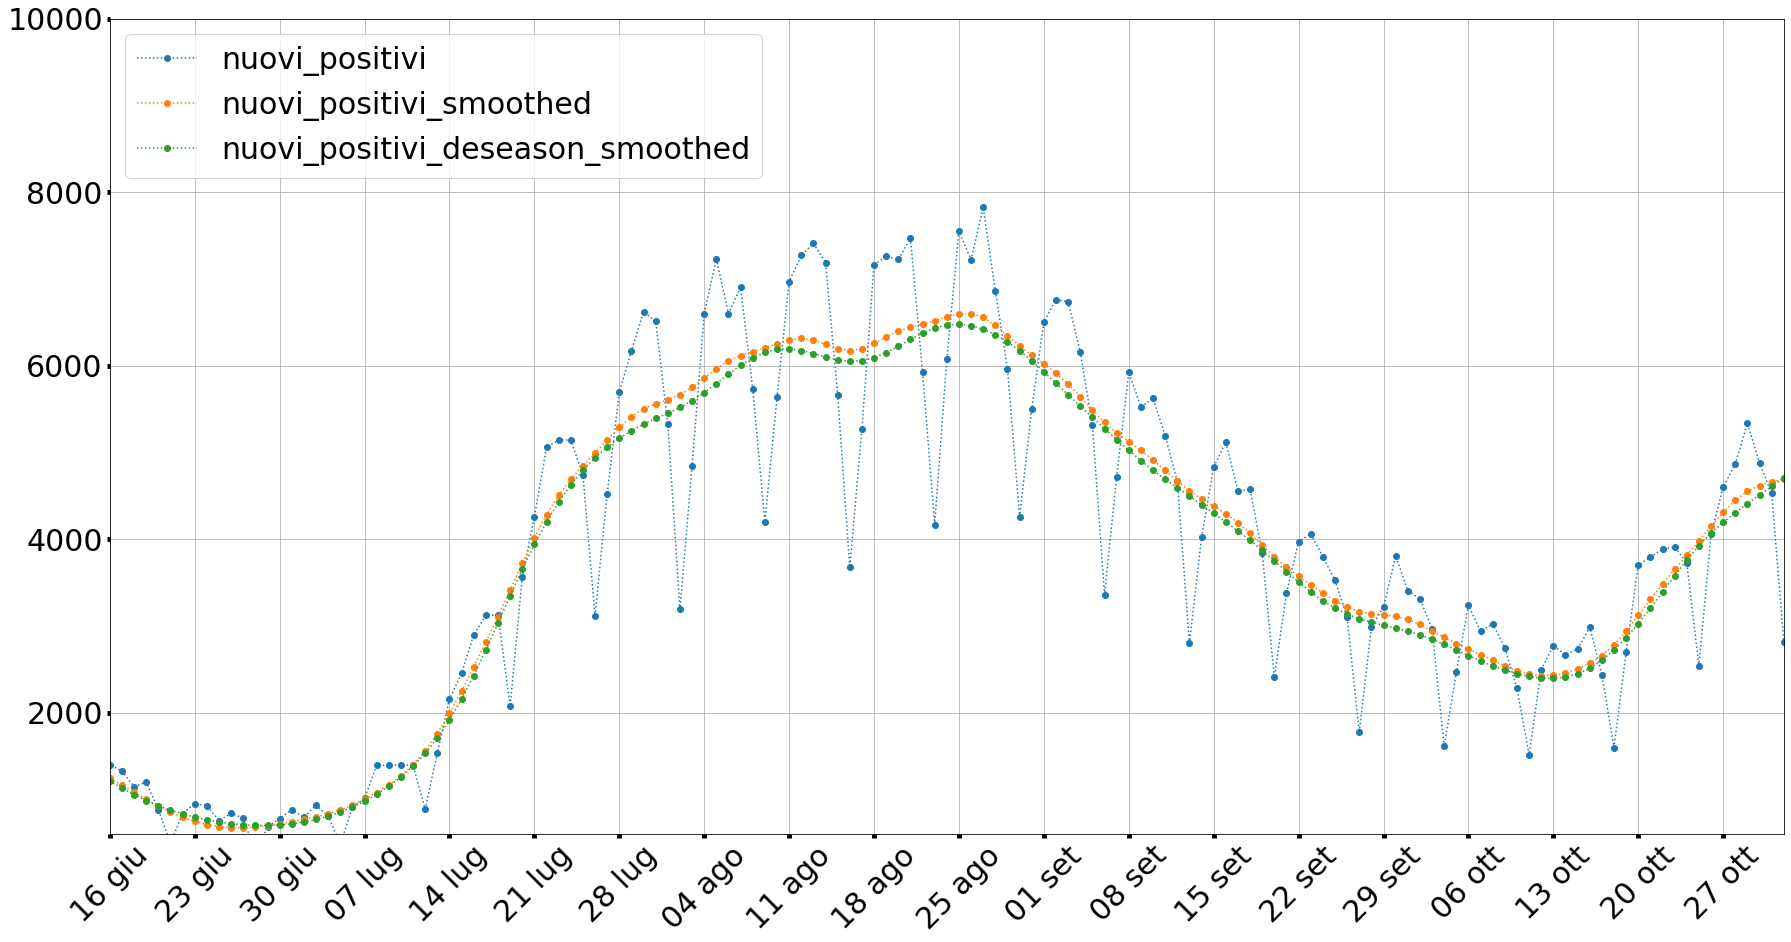

In [9]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    ylim=(600,10000),
    xlim=(datetime(2021,6,16), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

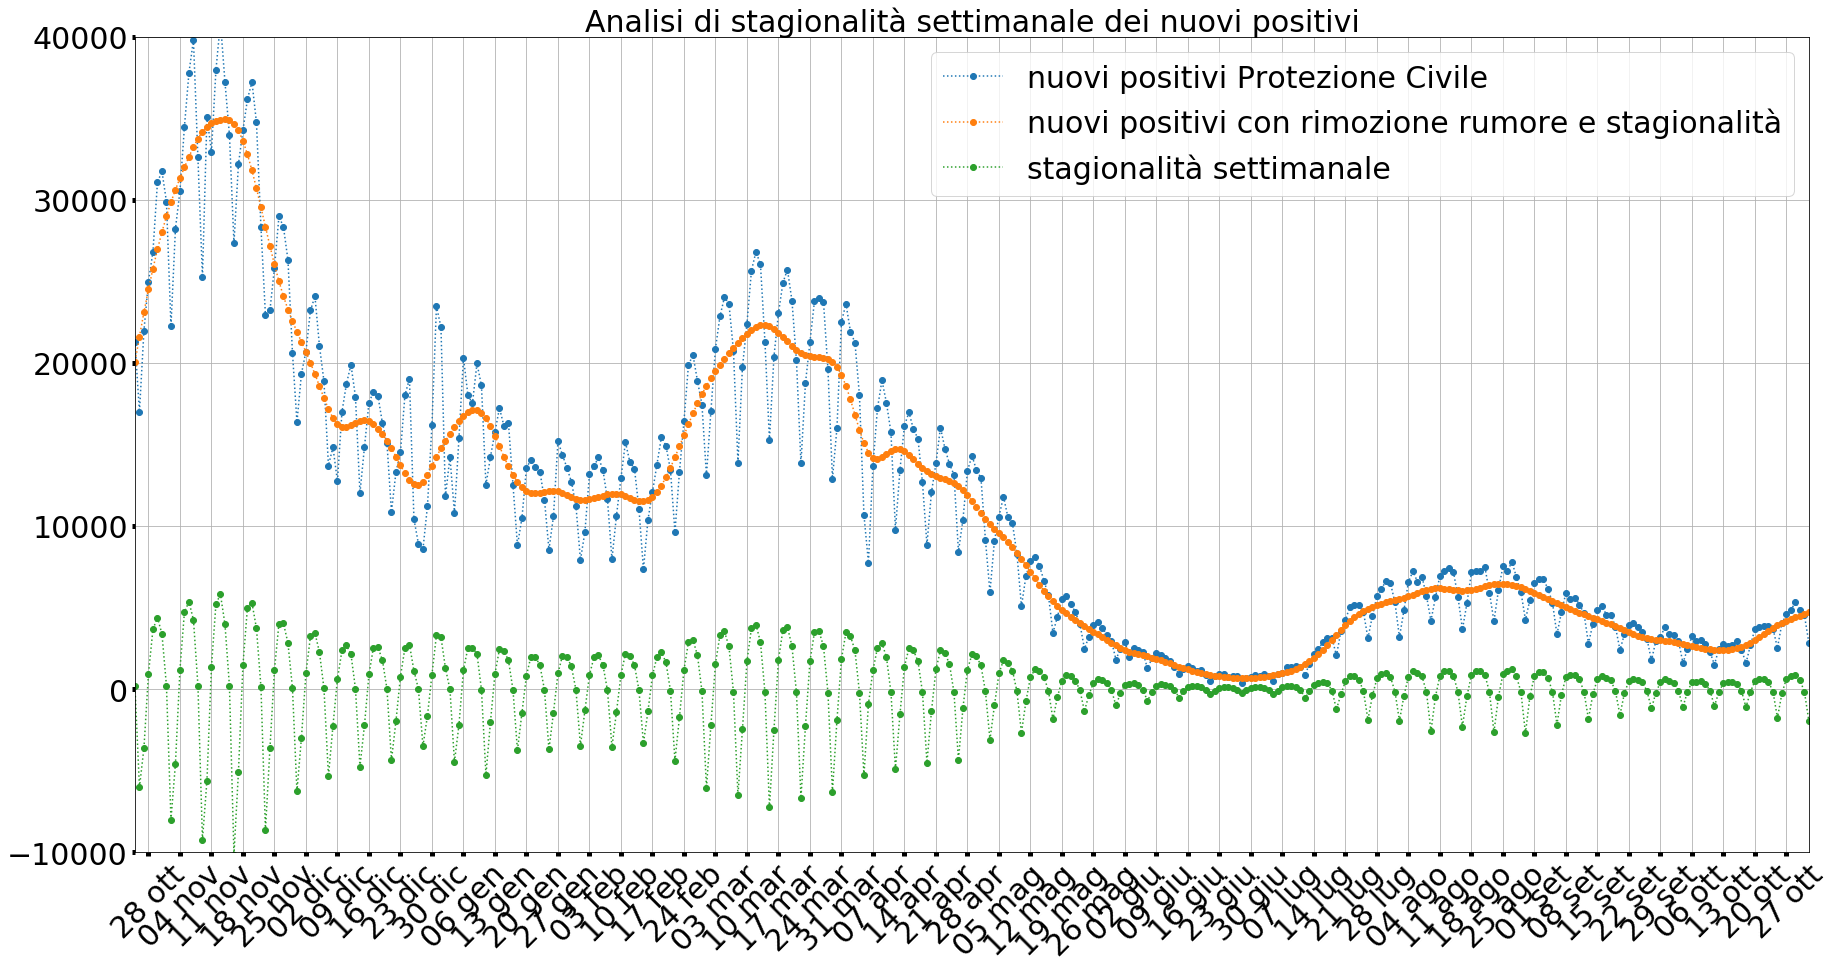

In [10]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi positivi',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2020,10,25), DPC_data.data.max()),
    ylim=(-10000,40000),
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper right"
)

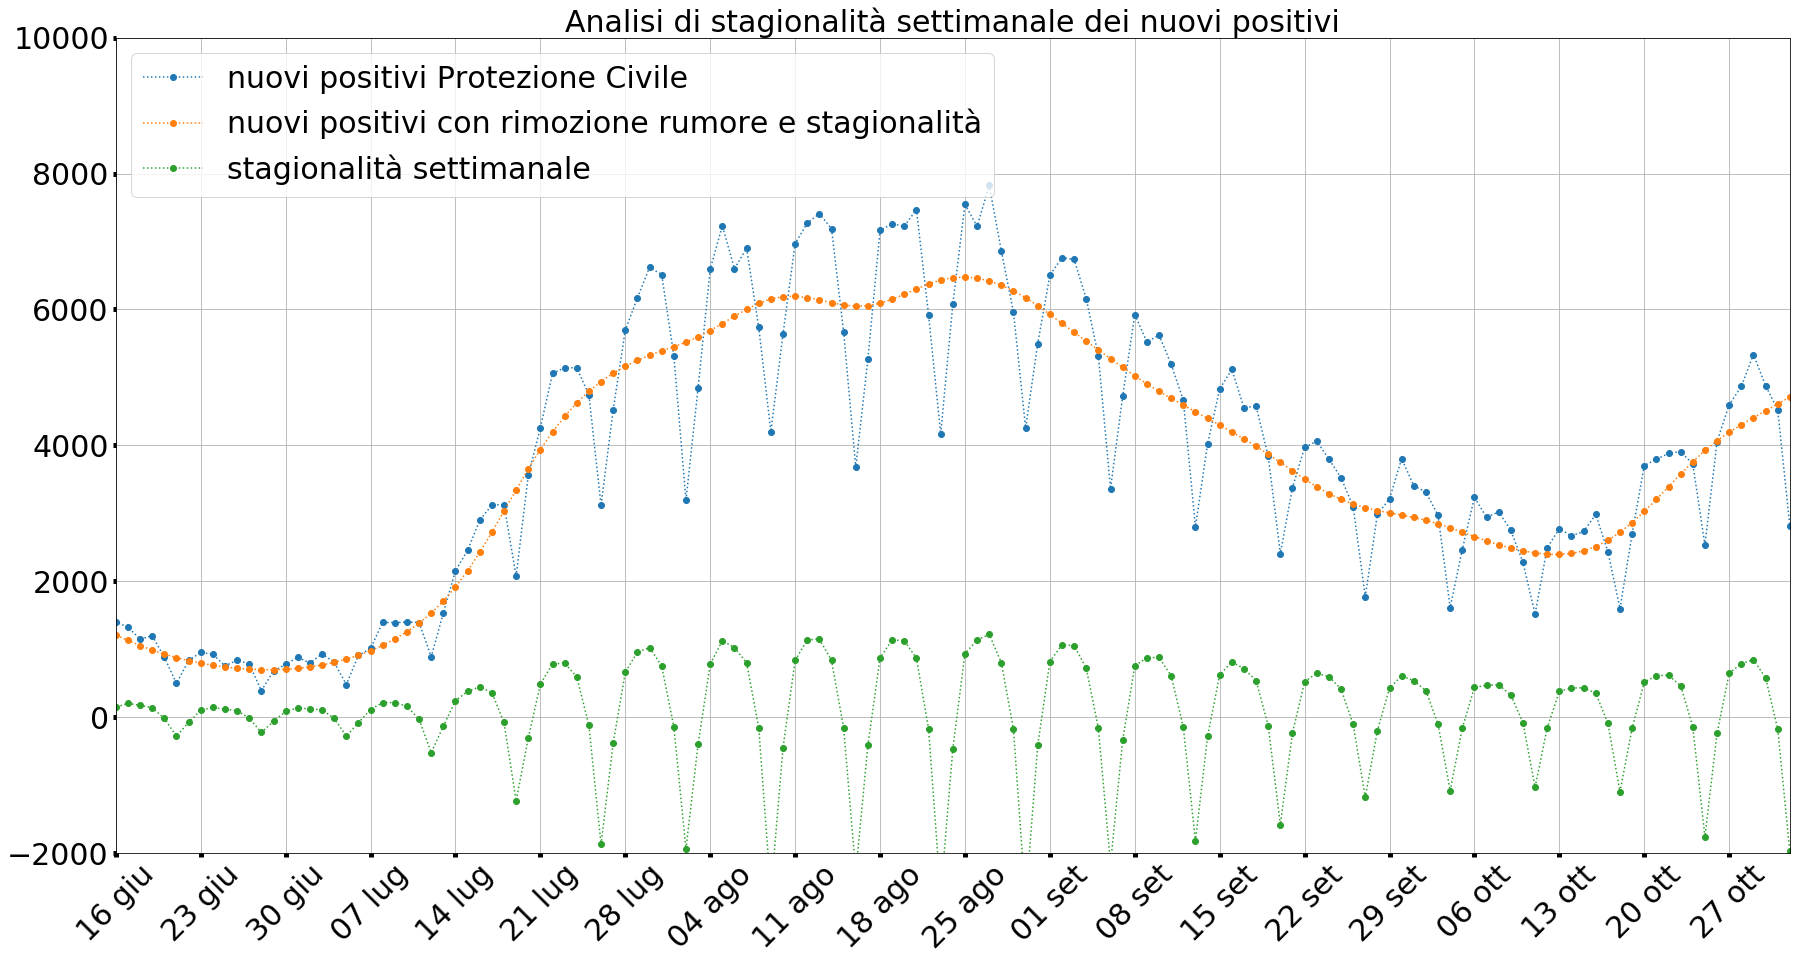

In [11]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi positivi',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2021,6,16), DPC_data.data.max()),
    ylim=(-2000,10000),
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper left"
)

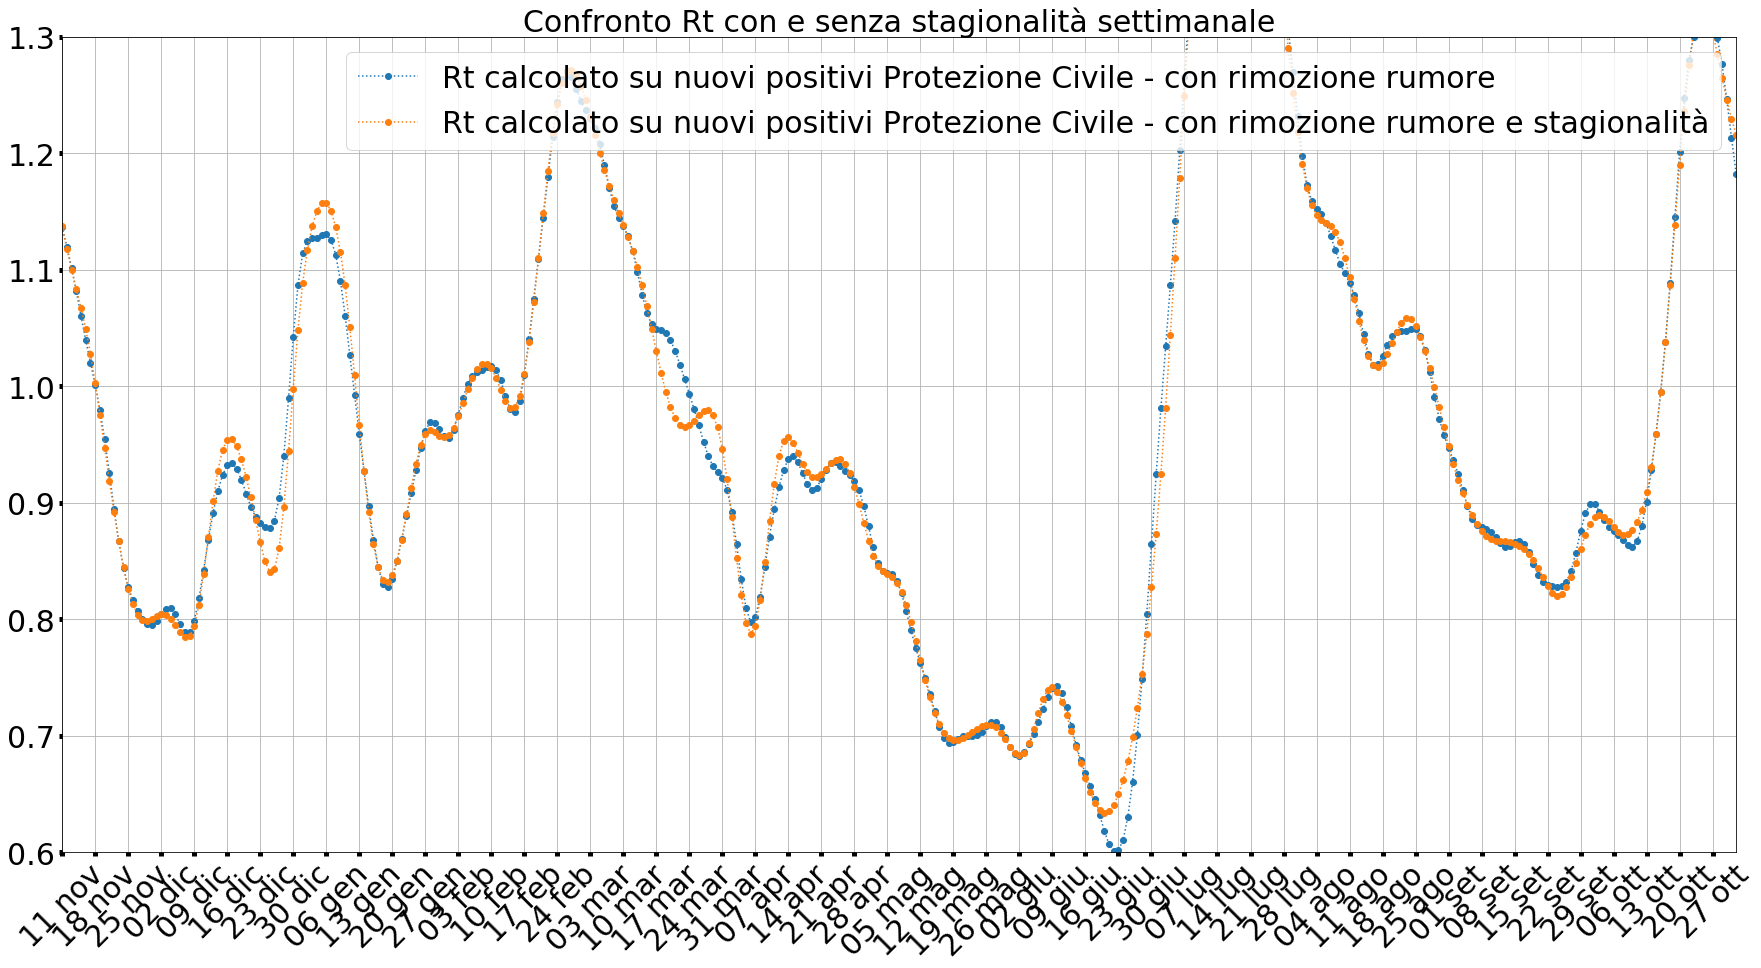

In [12]:
plotting.plot_series(
    title='Confronto Rt con e senza stagionalità settimanale',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_smoothed_Rt',
            'nuovi_positivi_deseason_smoothed_Rt', 
        ],
        'labels':[
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore',
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore e stagionalità',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    ylim=(0.6,1.3),
    legend_loc="upper right"
)

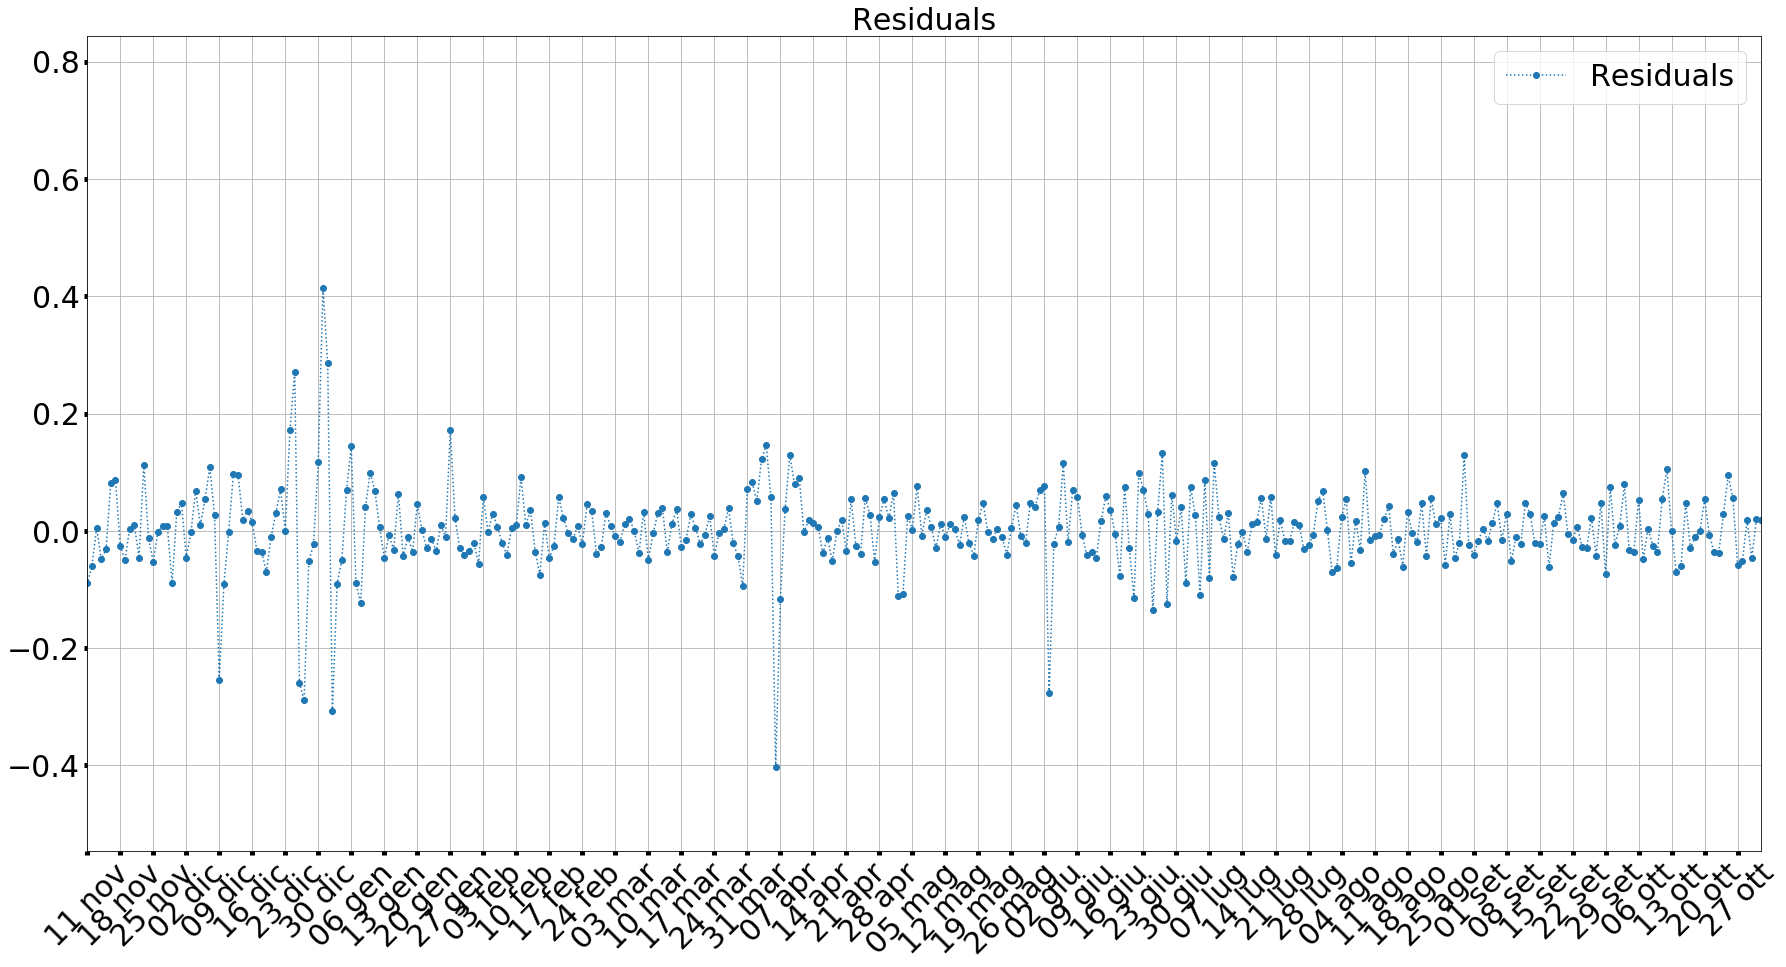

In [13]:
plotting.plot_series(
    title='Residuals',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_deseason_relative_residuals',
        ],
        'labels':[
            'Residuals',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    #ylim=(0.6,1.3),
    legend_loc="upper right"
)

## Distribution of residuals

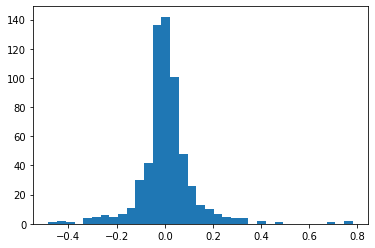

In [14]:
_=plt.hist(DPC_data.nuovi_positivi_deseason_relative_residuals,bins=35)

# Predict the next value of new cases

From the base formula for $R_t$:
$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

we can compute the next $I_{t+1}$ value, given $R_{t+1}$:

$$\large{{I_{t+1}} = R_{t+1} \times {\sum_{s=1}^{t+1} w_s I_{t+1-s}}}$$

$$s'=s-1$$

$$\large{{I_{t+1}} = R_{t+1} {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

Using Taylor to expand $R_{t+1}$:

$$R(t+dt) = R(t) + dR(t)dt + \frac{1}{2} d^2R(t) dt^2$$
$$R(t+\Delta t) = R(t) + \Delta R(t)\Delta t + \frac{1}{2} \Delta^2R(t) \Delta t^2$$
$$\Delta t = 1$$
$$R(t+1) = R(t) + [R(t)-R(t-1)] + \frac{1}{2} [R(t)-R(t-1)-(R(t-1)-R(t-2))]$$
$$ = 2R(t)-R(t-1) + \frac{1}{2} [R(t)-2R(t-1)+R(t-2)]$$
$$ = \frac{3}{2} R(t) - 2 R(t-1) +\frac{1}{2} R(t-2)$$

We finally have:
$$\large{{I_{t+1}} = \left[\frac{3}{2} R_t - 2 R_{t-1} +\frac{1}{2} R_{t-2} \right] {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

# Obtain the confidence interval from the predictions

$$\large{X_t = S_t + E_t}$$

where:
- $X$ is the original signal
- $S$ is the seasonal component
- $E$ is the deseasoned component

$$\large{E_t = T_t + \epsilon_t}$$

where:
- $T$ is the smoothed trend
- $\epsilon$ is the residual

$$\large{X_{t+1}= T_{t+1} + \epsilon_{t+1} + S_{t+1}}$$

where we can approximate $X_{t+1}$ with the following:
- $T_{t+1}$ is approximated via Taylor on the previous $R_t$ knowledge
- $\epsilon_{t+1}$ is sampled from a gaussian distribution of the relative residuals, with $\mu=AVG_{t-7}(\epsilon_t/T_t)$ and $\sigma=STD_{t-7}(\epsilon_t/T_t)$

- $S_{t+1}$ is approximated with taylor from the last $S_{t+1-period}$ known value

## Strategy:

1. deseason once and obtain $T, R, S$
2. with those sample multiple values of $X_{t+1}$ based on taylor expantion and the hypotesis that tomorrow new cases can range from `0.8` to `1.2` as many the cases of today, as from $T$
3. generate multiple possible series $X^i$ with $i$ spanning the samples
4. deseason again each of the possible series
5. drop the last value as it is tomorrow
6. use the obtained $T$ as the truth value for the posterior in MCMC, adding noise sampled from $\epsilon_t$

This strategy is implemented essentially in two functions:

#### `covid19_pytoolbox.modeling.datarevision.seasonal.draw_expanded_series`:
`draw_expanded_series` performs steps 1 to 4, with as many `draws` future scenario


#### `covid19_pytoolbox.modeling.Rt.bayesian.MCMC_sample`:
`MCMC_sample` perform step 6, by sampling $R_t$ and $\epsilon_t$  in 4 chains with 500 samples each, forcing the number of new cases to be Bernoulli distributed with respect to the trend $T$.

By iterating `MCMC_sample` on each draw from the previous steps, the method can accounts for data revision, as each draw is a possibile future scenario ranging from `0.8` to `1.2` wrt the current trend $T$.

In [15]:
def save_MCMC_sampling(df, column, trace, pastdays, interval=0.95, start=0):
    interval_frac = int(interval*100)
    sampling_mean = np.mean(trace['r_t'], axis=0)

    df[f'{column}_Rt_MCMC_pastdays_{pastdays:02d}'] = padnan(sampling_mean, (start,pastdays))
    

    #credible interval
    sampling_hdi = pm.stats.hpd(trace['r_t'], hdi_prob=interval)
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_min_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,0], (start,pastdays))
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_max_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,1], (start,pastdays))


In [16]:
# set the following to anything grater than 0 to compute Rt series based on past days values on new cases
# this is helpful in checking how the method is robust against data revision

PASTDAYS_BEGIN=0

draws = 5

for pastdays in range(PASTDAYS_BEGIN-1,-1,-1):

    if pastdays == 0:
        sl = np.s_[:]
    else:
        sl = np.s_[:-pastdays]
        
    new_cases = DPC_data.nuovi_positivi.to_numpy()[sl]
    
    new_cases_expanded = draw_expanded_series(
            new_cases, draws=draws, season_period=7, trend_alpha=ALPHA, difference_degree=2, 
            alpha=alpha, beta=beta, truncate=False
        )
        
    new_cases_smoothed, rel_eps, padding_left = smooth_and_drop(
        new_cases_expanded, season_period=7, trend_alpha=100.,difference_degree=2)
        
    simulations = []
    for new_cases_s, rel_eps_s in zip(new_cases_smoothed, rel_eps):        
        model_, trace_ = MCMC_sample(
            onset=new_cases_s[~np.isnan(new_cases_s)],
            alpha=alpha, beta=beta,
            rel_eps=rel_eps_s[~np.isnan(rel_eps_s)],
            eps_window=1,
            start=0, window=None,
            chains=4,
            tune=500,
            draws=500,
            cores=4,
            dry=False,
            progressbar=False
        )
        simulations.append(trace_)

    sampled_Rt = np.array([t['r_t'] for t in simulations])
    combined_trace = {'r_t': sampled_Rt.reshape((-1,sampled_Rt.shape[2]))}

    save_MCMC_sampling(
        DPC_data, 'nuovi_positivi_smooth_deseas', combined_trace, pastdays, interval=0.95, start=padding_left+1)

    
    DPC_data.to_pickle(os.path.join(BASE_DATA_PATH,'computed/WIP/deseason_MCMC_Rt.pickle'))

# Calculation

The actual simulations run on virtual machines on IBM Cloud via the scripts contained in the `applications/` dir.

Here we just load the pickles generated by the simulations.

In [17]:
italy_calc_data = pd.read_pickle(
    os.path.join(BASE_DATA_PATH, 
                 f'computed/italy/{date_}_futbound_08_12_National_MCMC_Rt_pastdays_{pastdays}_{pastdays}.pickle')
)

In [18]:
italy_calc_data.sort_values(by='data', inplace=True)
italy_calc_data.reset_index(drop=True, inplace=True)

## Save computed data to csv and excel

In [19]:
procdata_to_save = italy_calc_data.loc[
    italy_calc_data.data>"2020-03-01",
    [
        "data", 
        "nuovi_positivi",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}",
        f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}"
    ]
].sort_values(by="data", ascending=False)

procdata_to_save.rename(columns={
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}": "Rt",
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}": "Rt_interv_cred_min",
    f"nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}": "Rt_interv_cred_max",
}, inplace=True)

procdata_to_save.to_csv(
    os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.csv"),
    float_format='%.2f',
    index=False
)
procdata_to_save.to_excel(
    os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.xlsx"),
    float_format='%.2f',
    index=False        
)

# ISS Data

To allow for comparison with official $Rt$ calculation, we load official data from a static dataset which we update manually every week.

In [20]:
ISS_Rt = ISS.read_weekly_Rt_from_local()
ISS_Rt_clean = ISS.preprocess(ISS_Rt)
ISS_Rt_clean.tail()

,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
59,2021-09-08,2021-09-21,0.83,0.81,0.85,0.02,0.02,2021-09-14 23:59:00
60,2021-09-15,2021-09-28,0.83,0.81,0.86,0.03,0.02,2021-09-21 23:59:00
61,2021-09-22,2021-10-05,0.85,0.82,0.87,0.02,0.03,2021-09-28 23:59:00
62,2021-09-29,2021-10-12,0.86,0.82,0.90,0.04,0.04,2021-10-05 23:59:00
63,2021-10-06,2021-10-19,0.96,0.83,1.16,0.20,0.13,2021-10-12 23:59:00


In [21]:
def plot_simulation_results(
    simdf, ISSdf, xmin=datetime(2020,7,25), xmax=None, ylim=(0.2,2), 
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, 'TD_Rt_computation_MCMC_300dpi')):
    
    if not xmax:
        xmax = simdf.data.max()
        
    plotting.plot_series(
        title='',
        message='Aggiornamento del {}'.format(xmax.strftime('%d %b %Y')),
        data=[
            {
                'df': ISSdf,
                'xfield': 'Rt_reference_date',
                'yfields': ['Rt'],
                'bars': [['Rt_95_err_min','Rt_95_err_max']],
                'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
                'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
                'colors': ['blue']
            },        
            {
                'df': simdf,
                'xfield': 'data',
                'yfields': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
                ],
                'fill_between': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
                ],
                'labels': [
                    f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
                ],
                'colors':['orange']
            },
        ],
        legend_fontsize=27,
        xlim=(xmin, xmax),
        ylim=ylim,
        legend_loc='lower right',
        img_file_path_without_extension=img_file_path_without_extension,
        dpi=150,
        quality=60,
        tick_fontsize=20,
        major_formatter=mdates.DateFormatter("%d %b %y")
    )

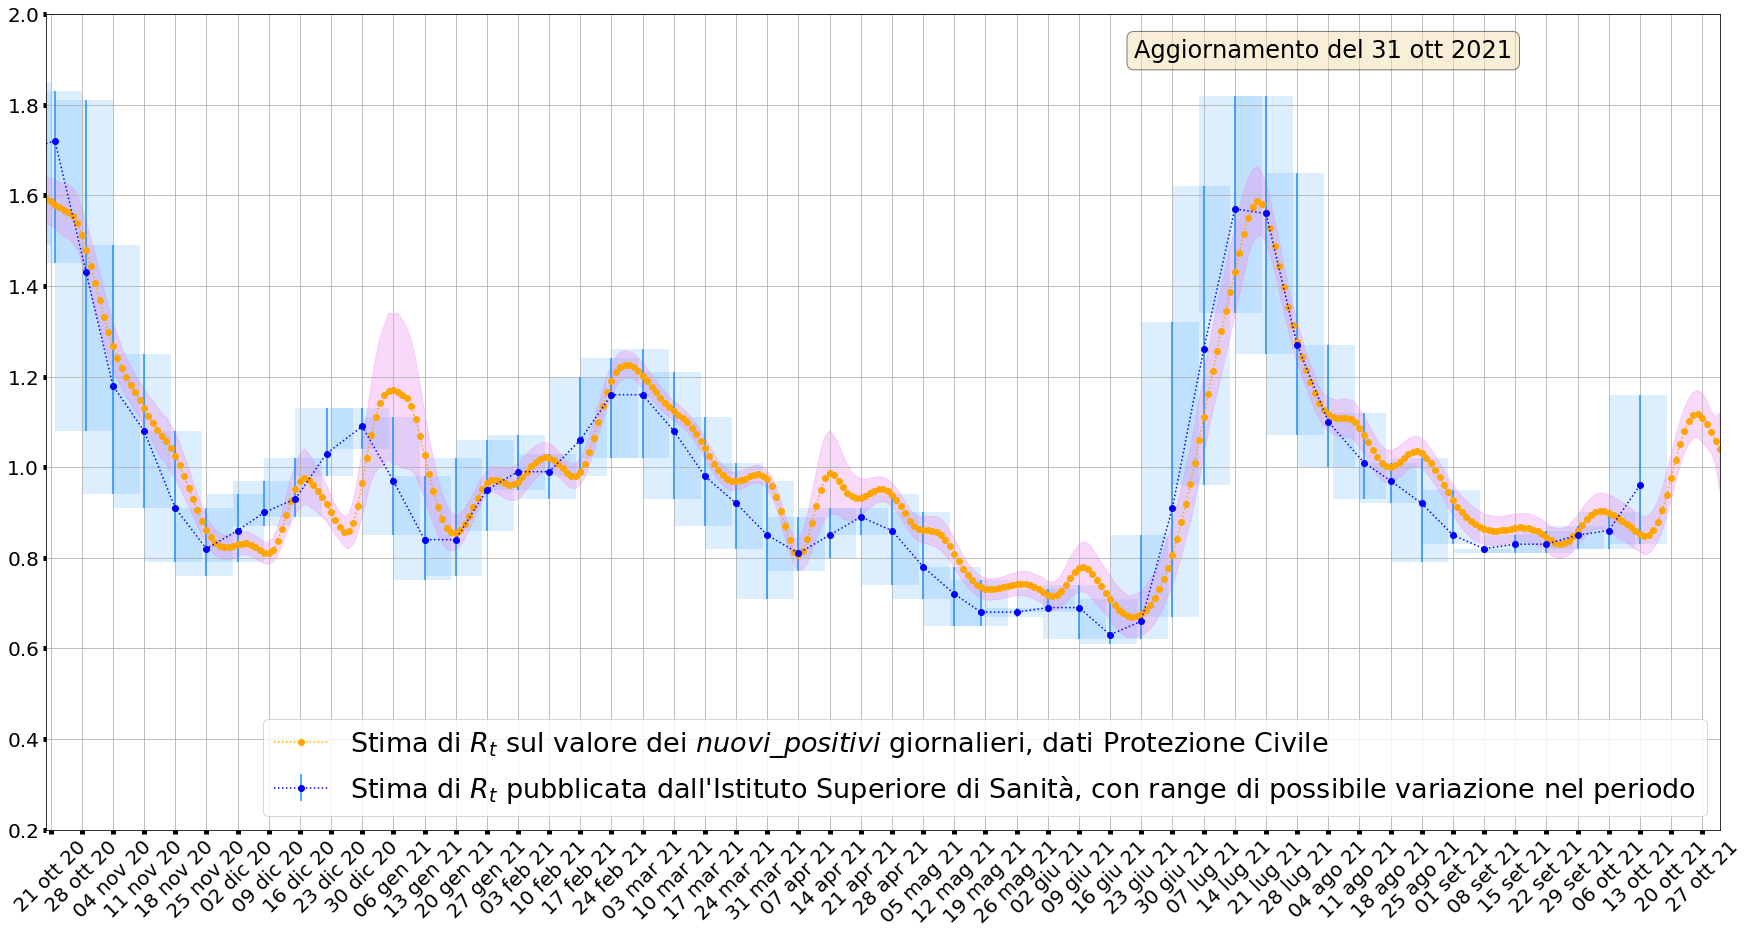

In [22]:
plot_simulation_results(
    simdf=italy_calc_data, ISSdf=ISS_Rt_clean, xmin=datetime(2020,10,20))#, xmax=datetime(2021,9,26)) #

In [23]:
italy_calc_data.set_index("data").tail().T

data,2021-10-27,2021-10-28,2021-10-29,2021-10-30,2021-10-31
stato,ITA,ITA,ITA,ITA,ITA
ricoverati_con_sintomi,2615,2609,2658,2707,2754
terapia_intensiva,341,347,349,346,342
totale_ospedalizzati,2956,2956,3007,3053,3096
isolamento_domiciliare,72409,73822,75637,77328,79352
totale_positivi,75365,76778,78644,80381,82448
variazione_totale_positivi,319,1413,1866,1737,2067
nuovi_positivi,4598,4866,5335,4878,4526
dimessi_guariti,4545049,4548449,4551882,4554985,4557417
deceduti,131954,132004,132037,132074,132100


In [24]:
italy_calc_data.tail(10)

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,imported,total,imported_ratio,imported_ratio_avg14,imported_ratio_std14,imported_ratio_shifted,nuovi_positivi_corrected,nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000
606,2021-10-22,ITA,2443,343,2786,70943,73729,-21,3882,4528065,...,NaN,NaN,NaN,NaN,NaN,0.128205,3384.307692,1.051135,1.001130,1.102238
607,2021-10-23,ITA,2455,338,2793,71223,74016,287,3908,4531644,...,NaN,NaN,NaN,NaN,NaN,0.128205,3406.974359,1.080404,1.030973,1.130047
608,2021-10-24,ITA,2473,341,2814,71961,74775,759,3725,4534584,...,NaN,NaN,NaN,NaN,NaN,0.128205,3247.435897,1.102988,1.052565,1.151579
609,2021-10-25,ITA,2579,338,2917,71737,74654,-121,2535,4537210,...,NaN,NaN,NaN,NaN,NaN,0.128205,2210.000000,1.115833,1.064269,1.164650
610,2021-10-26,ITA,2604,341,2945,72101,75046,392,4054,4540823,...,NaN,NaN,NaN,NaN,NaN,0.128205,3534.256410,1.117348,1.065039,1.169596
611,2021-10-27,ITA,2615,341,2956,72409,75365,319,4598,4545049,...,NaN,NaN,NaN,NaN,NaN,0.128205,4008.512821,1.108830,1.056022,1.163378
612,2021-10-28,ITA,2609,347,2956,73822,76778,1413,4866,4548449,...,NaN,NaN,NaN,NaN,NaN,0.128205,4242.153846,1.094384,1.043676,1.148159
613,2021-10-29,ITA,2658,349,3007,75637,78644,1866,5335,4551882,...,NaN,NaN,NaN,NaN,NaN,0.128205,4651.025641,1.077623,1.031078,1.124070
614,2021-10-30,ITA,2707,346,3053,77328,80381,1737,4878,4554985,...,NaN,NaN,NaN,NaN,NaN,0.128205,4252.615385,1.058743,1.006693,1.111434
615,2021-10-31,ITA,2754,342,3096,79352,82448,2067,4526,4557417,...,NaN,NaN,NaN,NaN,NaN,0.128205,3945.743590,1.039784,0.945008,1.119463


# compare $R_t$ and new admissions

In [25]:
ricoveri = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/ISS/covid_19-iss_2021-10-31T22:34:49+00:00.ricoveri.csv'),
    #parse_dates=['iss_date', 'DATARICOVERO1']
)

ricoveri.loc[ricoveri.RICOVERI=='<5',['RICOVERI']]=5
ricoveri.RICOVERI = ricoveri.RICOVERI.astype(int)
ricoveri.dropna(inplace=True)

ricoveri['data']= pd.to_datetime(
    ricoveri.DATARICOVERO1,
    format='%d/%m/%Y'
)

ricoveri.sort_values(by='data', inplace=True)
ricoveri.reset_index(drop=True, inplace=True)


In [44]:
ricoveri_stable = ricoveri.loc[ricoveri.data<"2021-10-25"].copy()

RSVD_smooth_data_generic(
    ricoveri_stable, ['RICOVERI'], 
    alpha, beta, 
    season_period=7, trend_alpha=100, difference_degree=4)

['RICOVERI']
RICOVERI_deseason
info_cri:  -0.9389297838411627
info_cri:  2.243828279802964
TIC R2: 0.9946826201758893
patterns: 1
(   -16.572603067502065,
    1.8644758144108125e-29,
    19,
    585,
    {   '1%': -3.4415777369651717,
        '10%': -2.569407951640003,
        '5%': -2.866493255736561},
    -709.9447040619661)
new columns generated:
[   'RICOVERI_deseason',
    'RICOVERI_deseason_seasonality',
    'RICOVERI_deseason_smoothed',
    'RICOVERI_deseason_residuals',
    'RICOVERI_deseason_relative_residuals',
    'RICOVERI_deseason_smoothed_Rt']


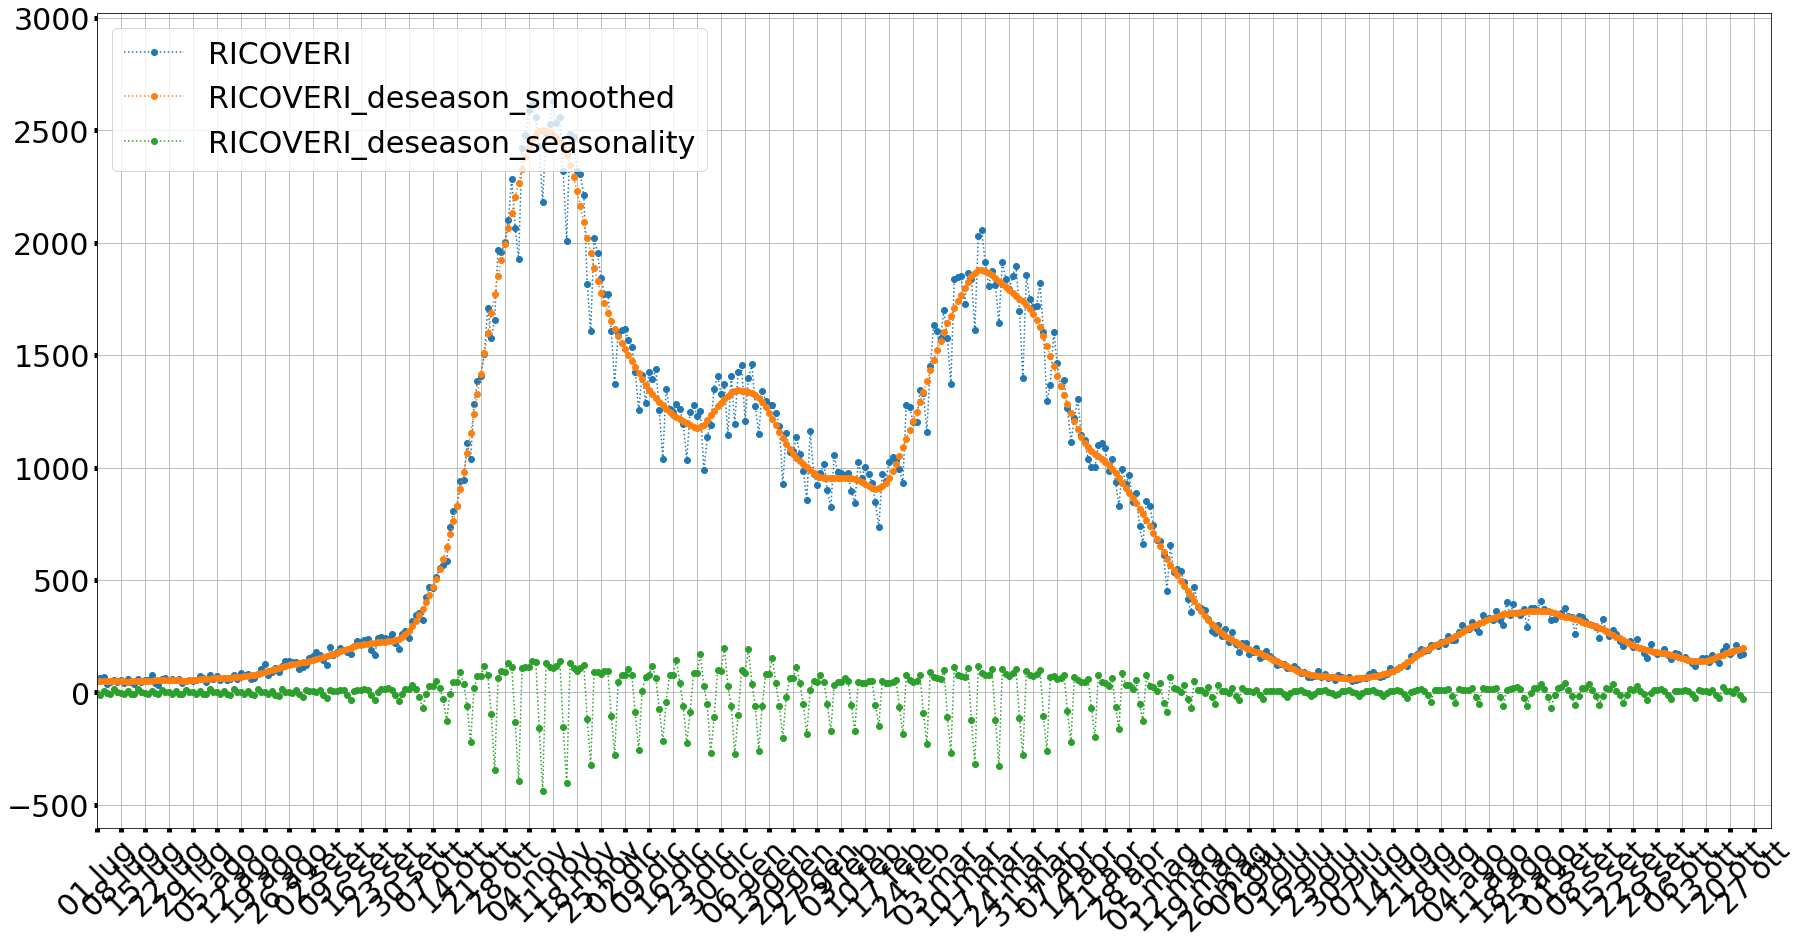

In [45]:
plotting.plot_series(
    df=ricoveri_stable,
    yfields=[
        'RICOVERI', 
        'RICOVERI_deseason_smoothed',
        'RICOVERI_deseason_seasonality'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,7,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

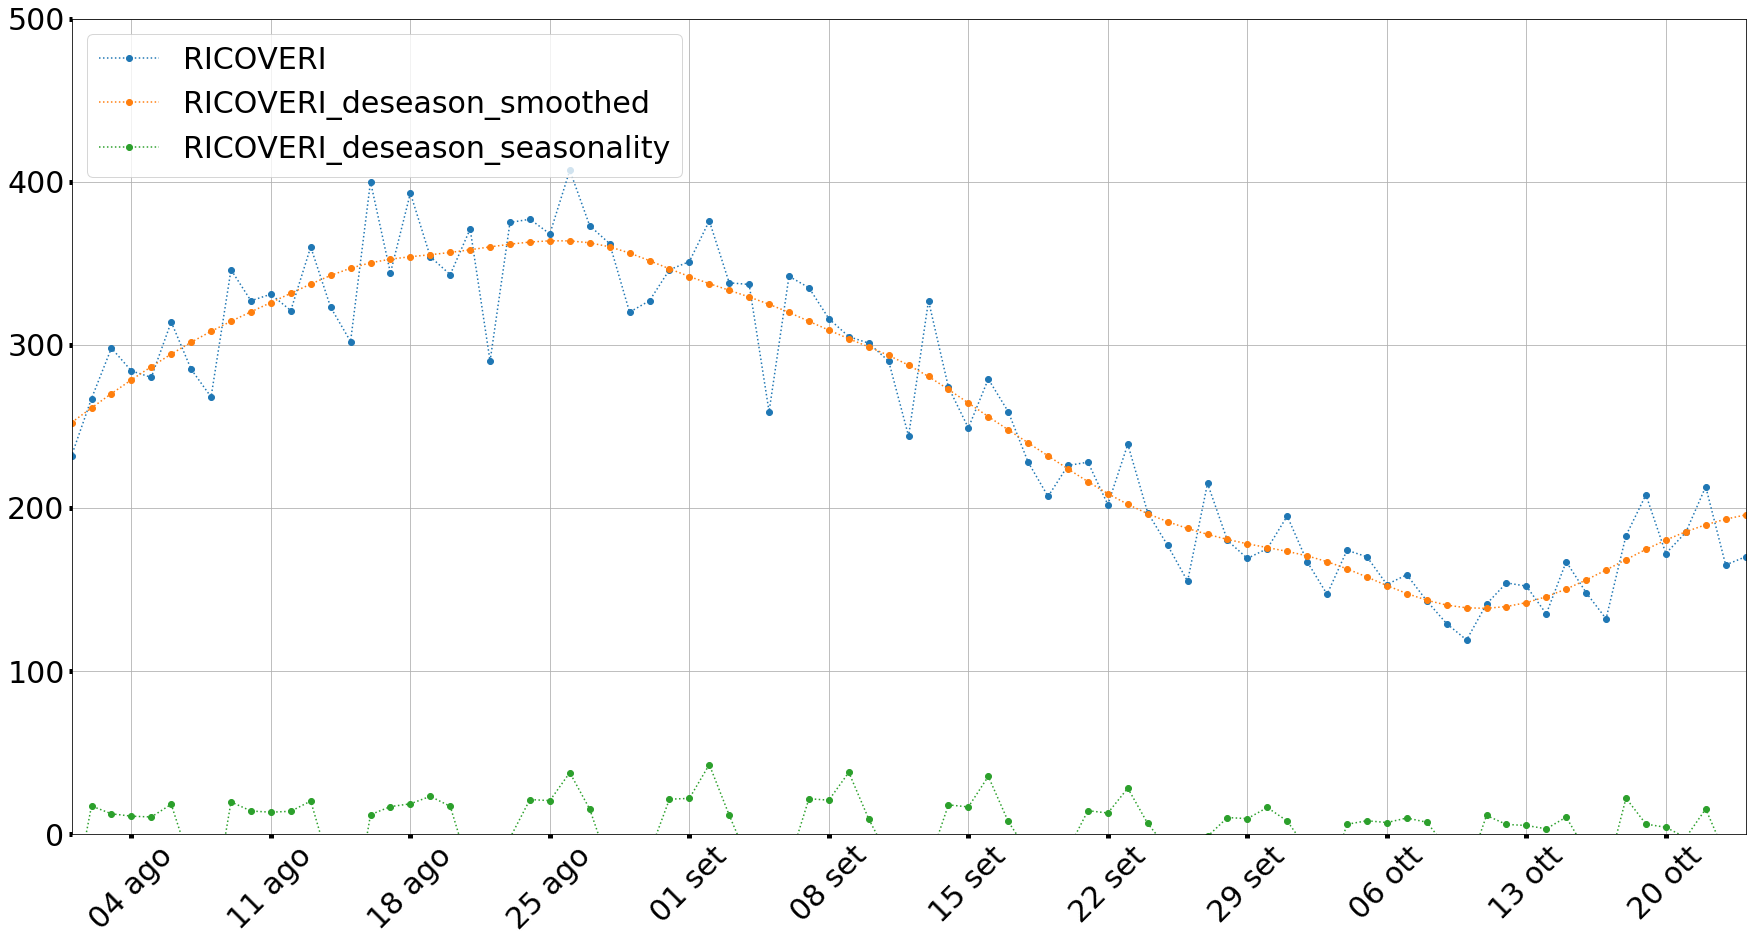

In [46]:
plotting.plot_series(
    df=ricoveri_stable,
    yfields=[
        'RICOVERI', 
        'RICOVERI_deseason_smoothed',
        'RICOVERI_deseason_seasonality'
    ],
    xlim=(datetime(2021,8,1), ricoveri_stable.data.max()),
    ylim=(0,500),
    legend_loc="upper left"
)

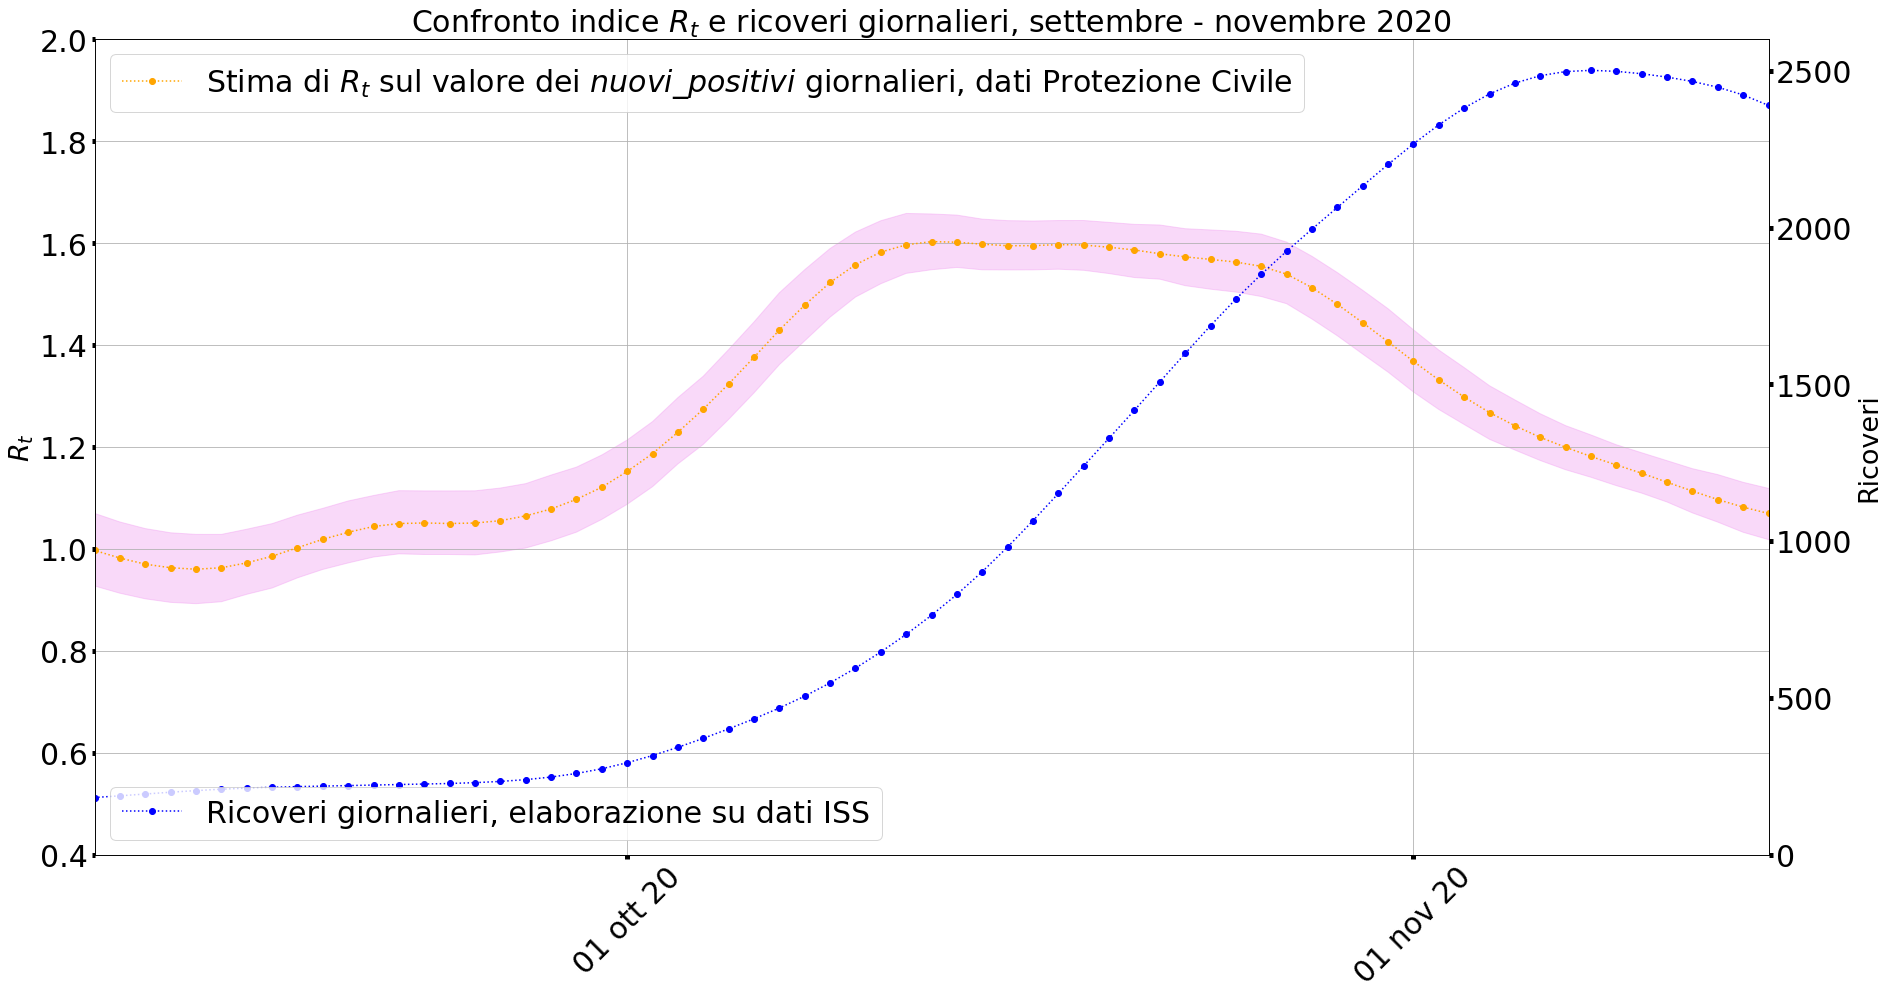

In [47]:
plotting.plot_series(
    title='Confronto indice $R_t$ e ricoveri giornalieri, settembre - novembre 2020',
    data=[
        {
            'df': italy_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
            ],
            'labels': [
                f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
        {
            'df': ricoveri_stable,
            'xfield': 'data',
            'yfields': ['RICOVERI_deseason_smoothed'],
            'colors': ['blue'],
            'secondary_ylim': (0,2600),
            'secondary_ylabel': "Ricoveri",
            'labels':['Ricoveri giornalieri, elaborazione su dati ISS']
        },        
    ],
    xlim=(datetime(2020,9,10), datetime(2020,11,15)),#DPC_data.data.max()),
    ylim=(0.4,2),
    y_label='$R_t$',
    #ylim=(-10000,40000),
    legend_loc="upper left",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, "italy/confr_rt_con_ricoveri_set_nov_2020"),
    dpi=150,
    quality=60
    
)


In [48]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-09-30")&(ricoveri_stable.data<="2020-10-06")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 274.3322950627422 433.6087642773767 159.27646921463446 58.05968603813362


In [49]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-06")&(ricoveri_stable.data<"2020-10-13")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 433.6087642773767 702.8678703220776 269.2591060447009 62.09724715630001


In [50]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-13")&(ricoveri_stable.data<"2020-10-20")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 763.8003887195962 1240.0780184078121 476.27762968821594 62.35629579694615


In [51]:
filt=ricoveri_stable[(ricoveri_stable.data>="2020-10-20")&(ricoveri_stable.data<"2020-10-27")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 1328.494674732778 1851.1244207847294 522.6297460519513 39.33999555979224


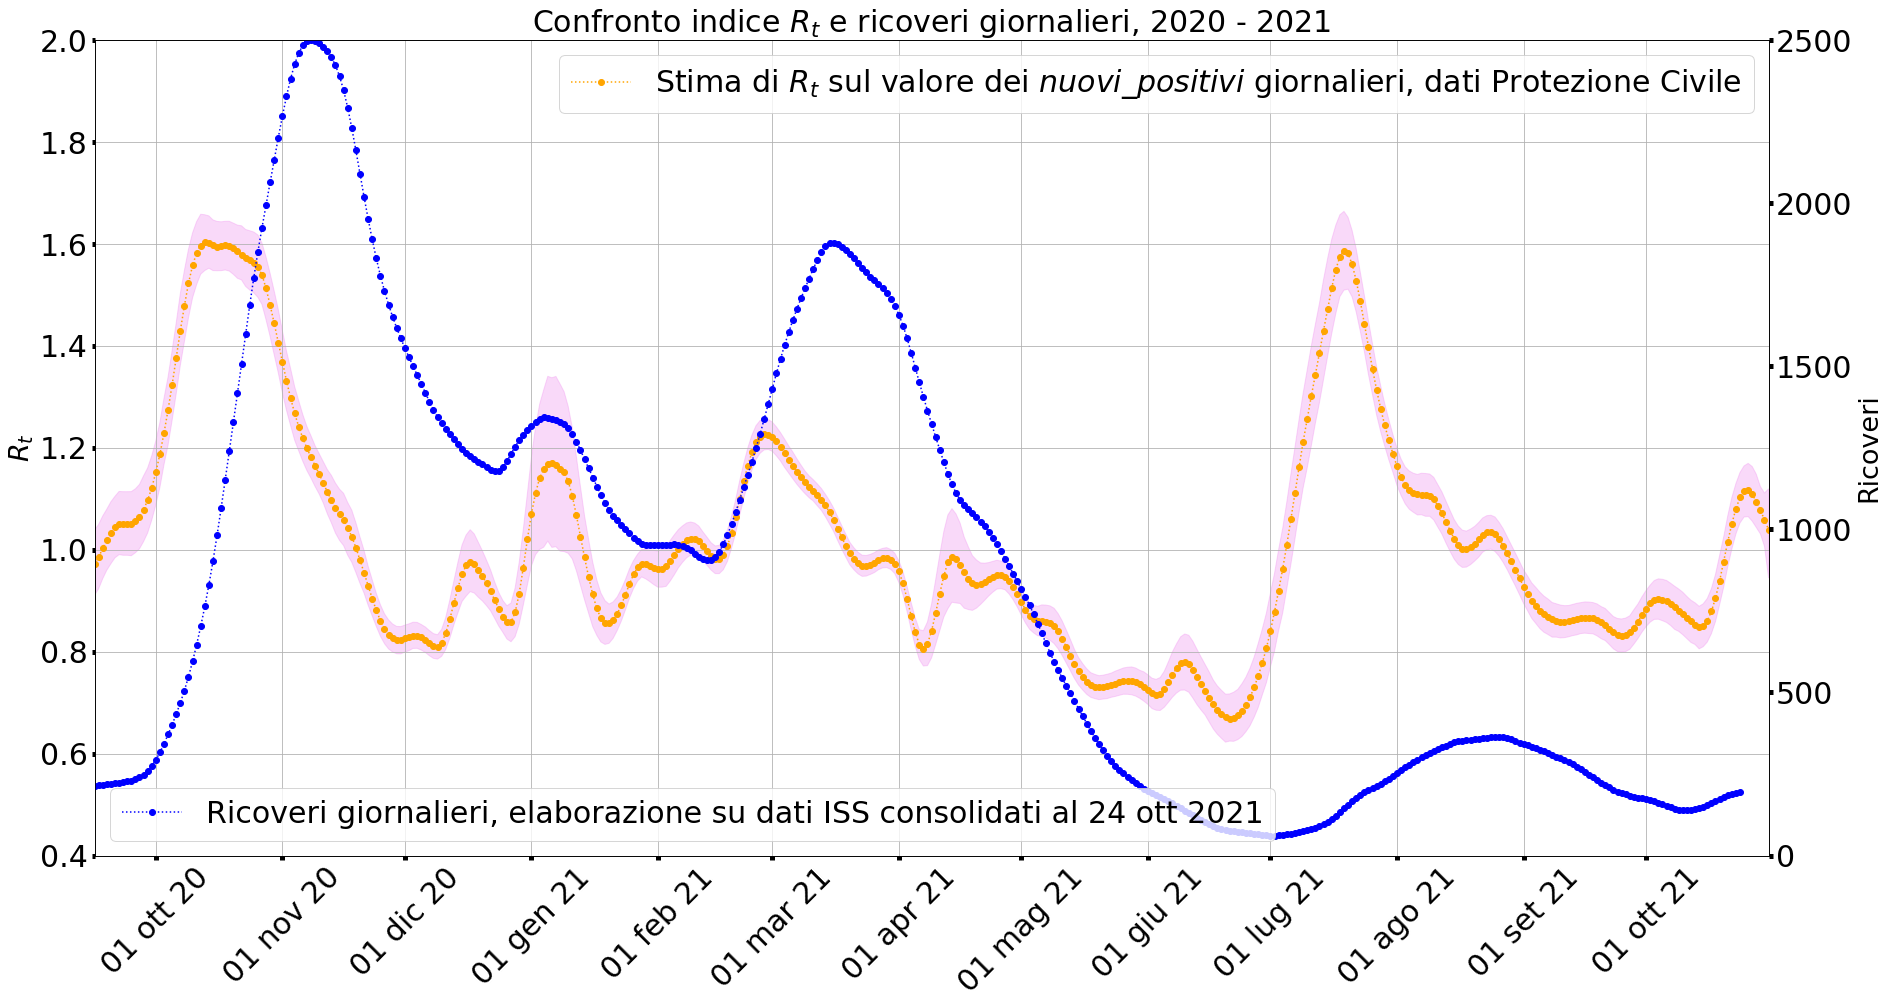

In [52]:
plotting.plot_series(
    title='Confronto indice $R_t$ e ricoveri giornalieri, 2020 - 2021',
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%d %b"),    
    data=[
        {
            'df': italy_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays}', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays}',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays}',
            ],
            'labels': [
                f'Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
        {
            'df': ricoveri_stable, #ricoveri[ricoveri.data<="2021-07-11"],
            'xfield': 'data',
            'yfields': ['RICOVERI_deseason_smoothed'],
            'colors': ['blue'],
            'secondary_ylim': (0,2500),
            'secondary_ylabel': "Ricoveri",
            'labels':[f'Ricoveri giornalieri, elaborazione su dati ISS consolidati al {ricoveri_stable.data.max().strftime("%d %b %Y")}']
        },        
    ],
    xlim=(datetime(2020,9,16), italy_calc_data.data.max()),
    ylim=(0.4,2),
    y_label='$R_t$',
    #tick_fontsize=22,
    #ylim=(-10000,40000),
    legend_loc="upper right",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, "italy/confr_rt_con_ricoveri_2020_2021"),
    dpi=150,
    quality=60,
)


In [53]:
ricoveri_stable[ricoveri_stable.data<="2021-10-18"]

,iss_date,DATARICOVERO1,RICOVERI,data,RICOVERI_deseason,RICOVERI_deseason_seasonality,RICOVERI_deseason_smoothed,RICOVERI_deseason_residuals,RICOVERI_deseason_relative_residuals,RICOVERI_deseason_smoothed_Rt
0,31/10/2021,20/02/2020,92,2020-02-20,NaN,NaN,NaN,NaN,NaN,NaN
1,31/10/2021,21/02/2020,122,2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN
2,31/10/2021,22/02/2020,106,2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN
3,31/10/2021,23/02/2020,152,2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN
4,31/10/2021,24/02/2020,191,2020-02-24,180.138474,10.861526,227.309324,-47.170850,-0.207518,NaN
...,...,...,...,...,...,...,...,...,...,...
602,31/10/2021,14/10/2021,135,2021-10-14,131.809940,3.190060,145.512409,-13.702469,-0.094167,0.972823
603,31/10/2021,15/10/2021,167,2021-10-15,156.638600,10.361400,150.224276,6.414324,0.042698,1.015284
604,31/10/2021,16/10/2021,148,2021-10-16,158.547583,-10.547583,155.789169,2.758413,0.017706,1.058464
605,31/10/2021,17/10/2021,132,2021-10-17,157.563384,-25.563384,161.917458,-4.354074,-0.026891,1.099357


In [36]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-11")&(ricoveri_stable.data<"2021-07-18")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 81.58402667390901 122.58609029194146 41.00206361803245 50.25746495930817


In [37]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-18")&(ricoveri_stable.data<"2021-07-24")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(6, 10) 133.4015474171875 186.91290583622018 53.51135841903269 40.11299677932992


In [38]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-24")&(ricoveri_stable.data<"2021-07-31")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 195.29119382235066 234.89508372673788 39.603889904387216 20.27940386314267


In [39]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-08-09")&(ricoveri_stable.data<"2021-08-16")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 314.3859265236906 346.9253013964191 32.5393748727285 10.350137244542495


In [40]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-14")&(ricoveri_stable.data<"2021-07-21")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 96.66462350706244 156.01234803764086 59.34772453057842 61.39549545366242


In [41]:
filt=ricoveri_stable[(ricoveri_stable.data>"2021-07-16")&(ricoveri_stable.data<="2021-07-23")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 122.58609029194146 186.91290583622018 64.32681554427872 52.47480802355552


In [42]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-07-24")&(ricoveri_stable.data<"2021-07-31")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(7, 10) 195.29119382235066 234.89508372673788 39.603889904387216 20.27940386314267


In [43]:
filt=ricoveri_stable[(ricoveri_stable.data>="2021-08-20")&(ricoveri_stable.data<="2021-09-04")]
minr, maxr = filt.RICOVERI_deseason_smoothed.min(), filt.RICOVERI_deseason_smoothed.max()
print(filt.shape, minr, maxr, maxr-minr, (maxr-minr)/minr*100)

(16, 10) 329.34678599173316 363.72254988492097 34.37576389318781 10.437558632817709
